In [1]:
using Revise

In [39]:
using QuantumStates, UnitsToValue, DataFrames, PrettyTables

### Load Hamiltonian

In [87]:
H = load_from_file("CaOH_X010", "C://Google Drive//github//QuantumStates//Hamiltonians//CaOH//")

# Add AC Stark effect from trap
au = 1.64877727436e-41

# ODT
# w = 25e-6; P = @with_unit 13.25 "W"; I_trap = 2P / (π * w^2);
# α_par = 142.6
# α_perp = 234.6

# Tweezer
w = 2.0e-6; P = @with_unit 0.130 "W"; I_trap = 2P / (π * w^2);
α_par = 186.5
α_perp = 393.2

const α = [(1/3)*(α_par + 2α_perp), 0, (2/3)*(α_par - α_perp)] .* au
const θ = π/2
const ϵ_trap = cos(θ) * [0.0, 1.0, 0.0] + sin(θ) * [1.0, 0.0, -1.0] / √2
scalar_polarizability(state, state′) = polarizability(state, state′, α .* [1,0,0], ϵ_trap)
tensor_polarizability(state, state′) = polarizability(state, state′, α .* [0,0,1], ϵ_trap)
H = add_to_H(H, :I_scalar, (1e-6 / h) * scalar_polarizability)
H = add_to_H(H, :I_tensor, (1e-6 / h) * tensor_polarizability)

# Add DC Stark effect
const μX = 1e-6 * 1.465 * (1e-21 / c) / h
H = add_to_H(H, :E, (1e2 * μX) * Stark) # 1e2 converts from V/m to V/cm

# Add Zeeman effect
Zeeman_z(state, state′) = Zeeman(state, state′, 0)
H = add_to_H(H, :B_z, gS * (1e-10 * μ_B / h) * Zeeman_z)
;

In [88]:
H.parameters.E = 0 * 0.3
H.parameters.B_z = 2.
H.parameters.I_scalar = (0.8/4) * I_trap / (2ε_0 * c)
H.parameters.I_tensor = (0.8/4) * I_trap / (2ε_0 * c)

H.parameters.bFX = 2.2
H.parameters.cX = 2.6

full_evaluate!(H)
solve!(H)
_, N1_J12_states = subspace(H.states, (N=1, J=1/2))
_, N1_J32_states = subspace(H.states, (N=1, J=3/2))
_, N2_J32_states = subspace(H.states, (N=2, J=3/2))
_, N2_states = subspace(H.states, (N=2,))
;

┌───────┬──────┬──────┬───────┬─────────┬──────┬──────┬───────┬─────────┬──────────────┐
│ State │    N │    F │     M │ State_1 │  N_1 │  F_1 │   M_1 │       f │          tdm │
├───────┼──────┼──────┼───────┼─────────┼──────┼──────┼───────┼─────────┼──────────────┤
│     4 │ 1//1 │ 0//1 │  0//1 │      26 │ 2//1 │ 2//1 │  1//1 │  55.306 │    0.0462211 │
│     3 │ 1//1 │ 1//1 │ -1//1 │      25 │ 2//1 │ 2//1 │  2//1 │  54.977 │    0.0139335 │
│     4 │ 1//1 │ 0//1 │  0//1 │      27 │ 2//1 │ 1//1 │  1//1 │ 54.6434 │     0.329776 │
│     3 │ 1//1 │ 1//1 │ -1//1 │      28 │ 2//1 │ 2//1 │  0//1 │ 53.8817 │    -0.291605 │
│     4 │ 1//1 │ 0//1 │  0//1 │      29 │ 2//1 │ 2//1 │ -1//1 │ 53.5231 │   -0.0213987 │
│     2 │ 1//1 │ 1//1 │  0//1 │      26 │ 2//1 │ 2//1 │  1//1 │  53.148 │     0.481209 │
│     1 │ 1//1 │ 1//1 │  1//1 │      25 │ 2//1 │ 2//1 │  2//1 │ 52.8919 │    -0.510455 │
│     3 │ 1//1 │ 1//1 │ -1//1 │      30 │ 2//1 │ 1//1 │  0//1 │ 52.6812 │     0.065296 │
│     2 │ 1//1 │ 1//1

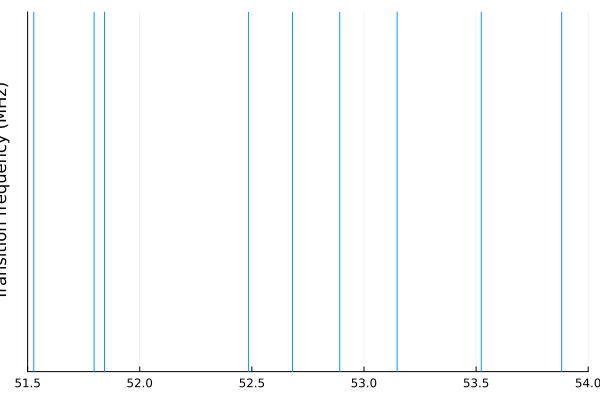

In [89]:
# |N=1, J=1/2, p=-⟩ -> |N=2, J=3/2, p=-⟩
transitions = compute_transitions(N1_J12_states, N2_J32_states, -1, threshold=1e-5)
# transitions = [transitions; compute_transitions(N1_J12_states, N2_J32_states, +1, threshold=1e-5)]
df = transitions_table(transitions)
select!(df, [:State, :N, :F, :M, :State_1, :N_1, :F_1, :M_1, :f, :tdm])
filter!(row -> 39900 < row.f < 39930, df)
df.f .= -(df.f .- 19985*2)

pretty_table(df; nosubheader=true)

using Plots
vline(df.f, legend=nothing)
plot!(
    xlim=(51.5, 54),
    yticks=nothing,
    ylabel="Transition frequency (MHz)"
)

┌───────┬───┬───┬───┬─────────┬─────┬─────┬─────┬───┬─────┐
│ State │ N │ F │ M │ State_1 │ N_1 │ F_1 │ M_1 │ f │ tdm │
└───────┴───┴───┴───┴─────────┴─────┴─────┴─────┴───┴─────┘


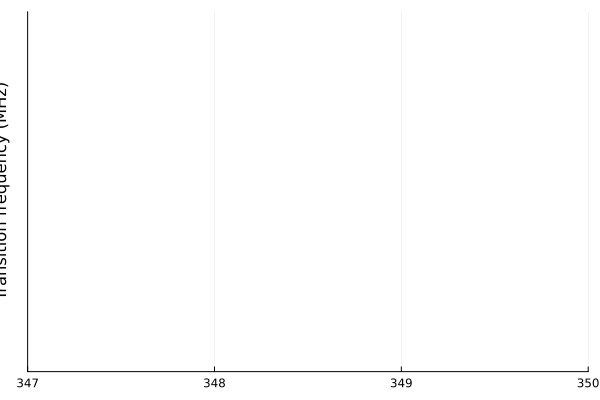

In [90]:
# |N=1, J=3/2, p=-⟩ -> |N=2, J=3/2, p=-⟩
transitions = compute_transitions(N1_J12_states, N2_J32_states, -1, threshold=1e-7)
# transitions = [transitions; compute_transitions(N1_J12_states, N2_J32_states, +1, threshold=1e-7)]
df = transitions_table(transitions)
select!(df, [:State, :N, :F, :M, :State_1, :N_1, :F_1, :M_1, :f, :tdm])
filter!(row -> row.f > 40030, df)
# filter!(row -> 39800 < row.f < 39980, df)
df.f .= df.f .- 19850*2

pretty_table(df; nosubheader=true)

using Plots
vline(df.f, legend=nothing)
plot!(
    xlim=(347, 350),
    yticks=nothing,
    ylabel="Transition frequency (MHz)"
)

┌───────┬──────┬──────┬───────┬─────────┬──────┬──────┬───────┬─────────┬──────────────┐
│ State │    N │    F │     M │ State_1 │  N_1 │  F_1 │   M_1 │       f │          tdm │
├───────┼──────┼──────┼───────┼─────────┼──────┼──────┼───────┼─────────┼──────────────┤
│    12 │ 1//1 │ 2//1 │  2//1 │      26 │ 2//1 │ 2//1 │  1//1 │ 185.916 │  -0.00431031 │
│    11 │ 1//1 │ 2//1 │  1//1 │      25 │ 2//1 │ 2//1 │  2//1 │ 186.305 │    0.0612752 │
│    12 │ 1//1 │ 2//1 │  2//1 │      27 │ 2//1 │ 1//1 │  1//1 │ 186.579 │   0.00485674 │
│    11 │ 1//1 │ 2//1 │  1//1 │      28 │ 2//1 │ 2//1 │  0//1 │ 187.401 │  -0.00547928 │
│     9 │ 1//1 │ 1//1 │  1//1 │      25 │ 2//1 │ 2//1 │  2//1 │ 187.584 │    0.0777512 │
│    12 │ 1//1 │ 2//1 │  2//1 │      29 │ 2//1 │ 2//1 │ -1//1 │ 187.699 │  0.000248136 │
│    10 │ 1//1 │ 2//1 │  0//1 │      26 │ 2//1 │ 2//1 │  1//1 │ 187.827 │     -0.11152 │
│    10 │ 1//1 │ 2//1 │  0//1 │      27 │ 2//1 │ 1//1 │  1//1 │ 188.489 │    0.0104043 │
│    11 │ 1//1 │ 2//1

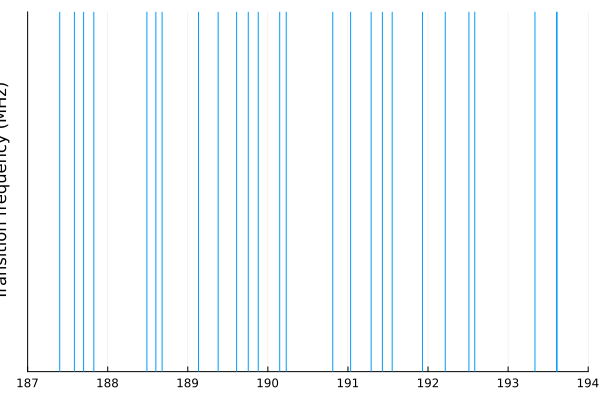

In [91]:
# |N=1, J=3/2, p=-⟩ -> |N=2, J=3/2, p=-⟩
transitions = compute_transitions(N1_J32_states, N2_J32_states, -1, threshold=1e-7)
# transitions = [transitions; compute_transitions(N1_J12_states, N2_J32_states, +1, threshold=1e-7)]
df = transitions_table(transitions)
select!(df, [:State, :N, :F, :M, :State_1, :N_1, :F_1, :M_1, :f, :tdm])
# filter!(row -> row.f > 40030, df)
filter!(row -> 39800 < row.f < 39950, df)
df.f .= df.f .- 19850*2

pretty_table(df; nosubheader=true)

using Plots
vline(df.f, legend=nothing)
plot!(
    xlim=(187,194),
    yticks=nothing,
    ylabel="Transition frequency (MHz)"
)

### Populating parity doublets

In [84]:
H.parameters.E = 0.
H.parameters.B_z = 2.
H.parameters.I_scalar = (0.8/4) * I_trap / (2ε_0 * c)
H.parameters.I_tensor = (0.8/4) * I_trap / (2ε_0 * c)

full_evaluate!(H)
solve!(H)
_, N1_J12_states = subspace(H.states, (N=1,))
_, N1_J32_states = subspace(H.states, (N=1, J=3/2))
;

┌───────┬──────┬──────┬───────┬─────────┬──────┬──────┬───────┬─────────┬─────────────┐
│ State │    N │    F │     M │ State_1 │  N_1 │  F_1 │   M_1 │       f │         tdm │
├───────┼──────┼──────┼───────┼─────────┼──────┼──────┼───────┼─────────┼─────────────┤
│     3 │ 1//1 │ 1//1 │ -1//1 │      17 │ 1//1 │ 1//1 │ -1//1 │ 65.7686 │  -0.0617539 │
│     4 │ 1//1 │ 0//1 │  0//1 │      18 │ 1//1 │ 2//1 │ -2//1 │ 66.3977 │ -0.00890506 │
│     4 │ 1//1 │ 0//1 │  0//1 │      19 │ 1//1 │ 1//1 │  0//1 │ 67.8025 │    0.249186 │
│     1 │ 1//1 │ 1//1 │  1//1 │      17 │ 1//1 │ 1//1 │ -1//1 │ 67.8538 │ -0.00507938 │
│     2 │ 1//1 │ 1//1 │  0//1 │      18 │ 1//1 │ 2//1 │ -2//1 │ 68.5557 │ 0.000135243 │
│     3 │ 1//1 │ 1//1 │ -1//1 │      20 │ 1//1 │ 2//1 │ -1//1 │ 69.1452 │    -0.23512 │
│     2 │ 1//1 │ 1//1 │  0//1 │      19 │ 1//1 │ 1//1 │  0//1 │ 69.9605 │  0.00285528 │
│     4 │ 1//1 │ 0//1 │  0//1 │      22 │ 1//1 │ 2//1 │  0//1 │ 70.1235 │ -0.00767469 │
│     3 │ 1//1 │ 1//1 │ -1//1 │ 

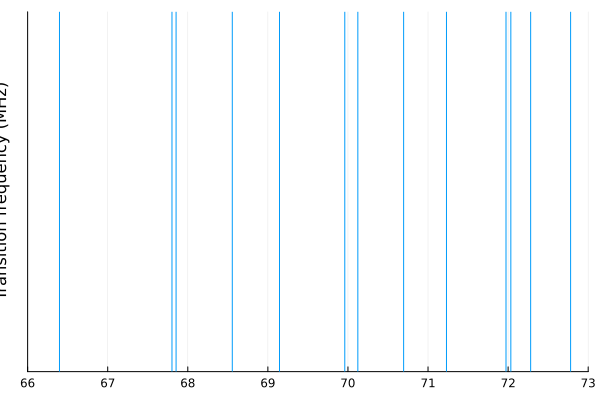

In [93]:
transitions = compute_transitions(H.states[[1,2,3,4]], N1_J32_states, 0, threshold=1e-5)
df = transitions_table(transitions)
select!(df, [:State, :N, :F, :M, :State_1, :N_1, :F_1, :M_1, :f, :tdm])
df.f .+= 0.2

pretty_table(df; nosubheader=true)

using Plots
vline(df.f, legend=nothing)
plot!(
    xlim=(66,73),
    yticks=nothing,
    ylabel="Transition frequency (MHz)"
)

┌───────┬──────┬──────┬───────┬─────────┬──────┬──────┬──────┬─────────┬─────────────┐
│ State │    N │    F │     M │ State_1 │  N_1 │  F_1 │  M_1 │       f │         tdm │
├───────┼──────┼──────┼───────┼─────────┼──────┼──────┼──────┼─────────┼─────────────┤
│    12 │ 1//1 │ 2//1 │  2//1 │      21 │ 1//1 │ 1//1 │ 1//1 │ 41.1649 │  -0.0319966 │
│    12 │ 1//1 │ 2//1 │  2//1 │      22 │ 1//1 │ 2//1 │ 0//1 │ 41.3408 │   0.0133662 │
│    11 │ 1//1 │ 2//1 │  1//1 │      21 │ 1//1 │ 1//1 │ 1//1 │ 41.9374 │    0.158982 │
│    11 │ 1//1 │ 2//1 │  1//1 │      22 │ 1//1 │ 2//1 │ 0//1 │ 42.1133 │   0.0525479 │
│    12 │ 1//1 │ 2//1 │  2//1 │      23 │ 1//1 │ 2//1 │ 1//1 │ 42.4837 │   0.0163567 │
│    10 │ 1//1 │ 2//1 │  0//1 │      21 │ 1//1 │ 1//1 │ 1//1 │ 43.0802 │  -0.0399115 │
│     9 │ 1//1 │ 1//1 │  1//1 │      21 │ 1//1 │ 1//1 │ 1//1 │ 43.2562 │   -0.209906 │
│    11 │ 1//1 │ 2//1 │  1//1 │      23 │ 1//1 │ 2//1 │ 1//1 │ 43.2562 │    0.387186 │
│    12 │ 1//1 │ 2//1 │  2//1 │      24 │ 1

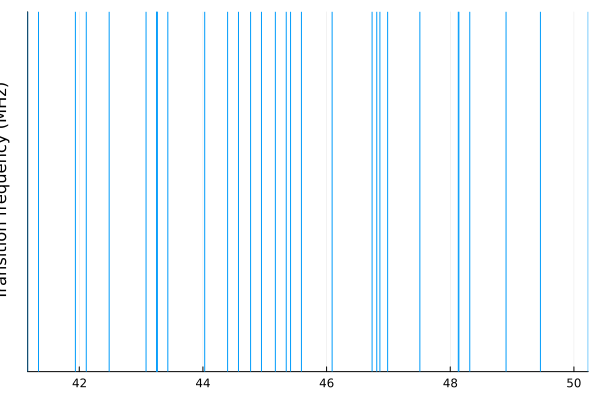

In [86]:
transitions = compute_transitions(H.states[[5,6,7,8,9,10,11,12]], N1_J32_states[[13,14,15,16]], 0, threshold=1e-5)
df = transitions_table(transitions)
select!(df, [:State, :N, :F, :M, :State_1, :N_1, :F_1, :M_1, :f, :tdm])
df.f .+= 0.2

pretty_table(df; nosubheader=true)

using Plots
vline(df.f, legend=nothing)
plot!(
    # xlim=(66,73),
    yticks=nothing,
    ylabel="Transition frequency (MHz)"
)

### Stark plots

In [489]:
function H_func!(H, scan_values)
    H.parameters.E = scan_values[1]
    evaluate!(H)
    solve!(H)
    return nothing
end

Es = (0:0.2:20.0)
scan_params = (
    E = Es,
    );
iterator = Iterators.product
@time scan_values, _ = scan_parameters(deepcopy(H), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=10)
matrix_values = hcat(values(scan_values)...)'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.890287 seconds (335.76 k allocations: 180.425 MiB, 131.82% compilation time)


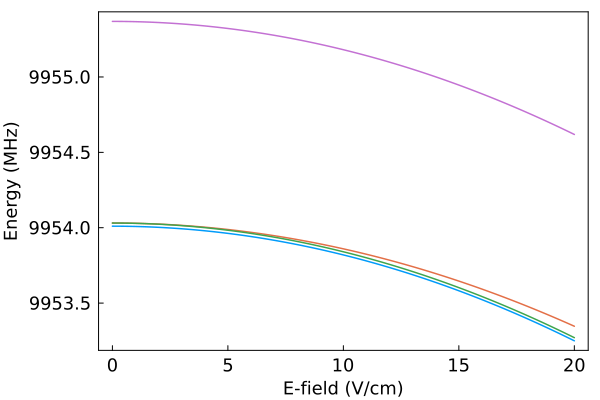

In [490]:
using Plots, LaTeXStrings
Es_rel = matrix_values #.- matrix_values[1,:]'
plot(Es, Es_rel[:,1:4], linewidth=1.5)
plot!(
    legend=nothing,
    xlabel="E-field (V/cm)",
    ylabel="Energy (MHz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on
    )

### Zeeman plots

In [494]:
function H_func!(H, scan_values)
    H.parameters.B_z = scan_values[1]
    evaluate!(H)
    solve!(H)
    return nothing
end

Bs = (0:0.01:2)
scan_params = (
    B = Bs,
    );
iterator = Iterators.product
@time scan_values, _ = scan_parameters(deepcopy(H), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=10)
matrix_values = hcat(values(scan_values)...)'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


  1.525651 seconds (400.23 k allocations: 273.861 MiB, 4.71% gc time, 61.27% compilation time)


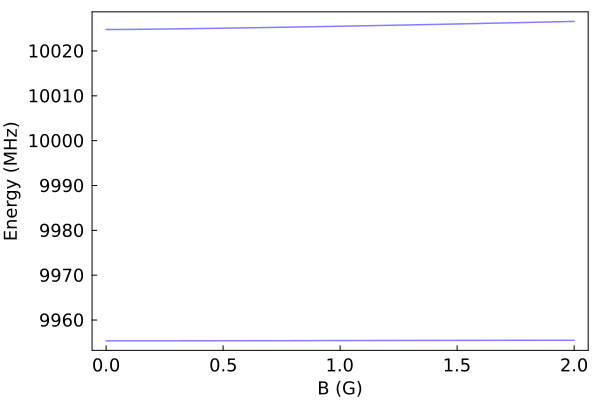

In [496]:
using Plots, LaTeXStrings
plot(Bs, matrix_values[:,[4,24]], linewidth=1.5, linecolor=:blue, alpha=0.5)
plot!(
    legend=nothing,
    xlabel="B (G)",
    ylabel="Energy (MHz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on
    )

### Transition dipole moments for X(010) - A(010)

In [1199]:
H_X010 = load_from_file("CaOH_X010", "C://Google Drive//github//QuantumStates//Hamiltonians//CaOH//")
H_A000 = load_from_file("CaOH_A000", "C://Google Drive//github//QuantumStates//Hamiltonians//CaOH//")
X010_states_caseA = convert_basis(H_X010.states, H_A000.basis)

H_A010 = load_from_file("CaOH_A010", "C://Google Drive//github//QuantumStates//Hamiltonians//CaOH//")
;

In [1200]:
A_N1_J12_states = H_A010.states[145:148];

In [1213]:
energy(H_A010.states[1]) * 1e-6

489.0045699064211

In [1215]:
energy(H_A010.states[5]) * 1e-6

489.0045719019248

##### To N=1, J=1/2 states

In [1164]:
N1_J12_states = X010_states_caseA[1:4]
sum(TDM(X_state, A_state, p) for X_state in N1_J12_states, A_state in A_N1_J12_states, p in -1:1)

0.7050503196786648 + 0.0im

##### To N=1, J=3/2 states

In [1165]:
N1_J32_states = X010_states_caseA[5:12]
sum(TDM(X_state, A_state, p) for X_state in N1_J32_states, A_state in A_N1_J12_states, p in -1:1)

-0.2692401294283998 + 0.0im

##### To N=2 states

In [1166]:
N2_states = X010_states_caseA[25:64]
sum(TDM(X_state, A_state, p) for X_state in N2_states, A_state in A_N1_J12_states, p in -1:1)

-0.28759887357941666 + 0.0im